In [28]:
setwd('C:/Users/User/Documents')
options(warn = -1)
pacotes <- c("tidyquant", "timetk","tidyverse", "PortfolioAnalytics",
             "corrplot")
for(i in pacotes){
  suppressPackageStartupMessages(library(i, character.only = T))
}

In [38]:
acoes <- c("TRPL4.SA","ABEV3.SA","B3SA3.SA","AGRO3.SA","ITSA4.SA","ENAT3.SA","VVAR3.SA","SEER3.SA")
n_acoes <- c(3,2,1,1,3,2,1,1)
n_tot <- data.frame(symbol = acoes, n = n_acoes)
data_inicio <- "2000-01-01"
mudanca_recente <- "2020-10-01"

In [39]:
dividendos <- tq_get(acoes, "dividends", from = data_inicio) %>%
  left_join(n_tot, by = c("symbol" = "symbol")) %>%
  group_by(symbol,date) %>%
  summarise(value = value*n)
precos <- tq_get(acoes, from = first(dividendos$date)) %>%
    select(date, symbol, adjusted) %>%
    left_join(n_tot, by = c("symbol" = "symbol")) %>%
    group_by(symbol, date) %>%
    summarise(adjusted = adjusted*n) %>%
    spread(key = symbol, value = adjusted) %>%
    na.omit %>%
    gather(key = "symbol", value = "adjusted", -c(date))

`summarise()` regrouping output by 'symbol' (override with `.groups` argument)

`summarise()` regrouping output by 'symbol' (override with `.groups` argument)



In [40]:
tot <- left_join(precos, dividendos, by = c("date"="date", "symbol"= "symbol"))
tot[,4] <- na.fill(tot[,4], 0)

In [41]:
dy <- tot %>%
  group_by(date) %>%
  summarise(dy = sum(value)/sum(adjusted)) %>%
  mutate(ano = year(date)) %>%
  group_by(ano) %>%
  summarise(dy = sum(dy))
dividendos_a <- tot %>%
  mutate(ano = year(date)) %>%
  group_by(ano, symbol) %>%
  na.omit() %>%
  summarise(Dividendos = sum(value), Preço = last(adjusted))
tot_g <- dividendos_a %>%
  gather(key = "data", value = "prices", -c(ano, symbol))

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'ano' (override with `.groups` argument)



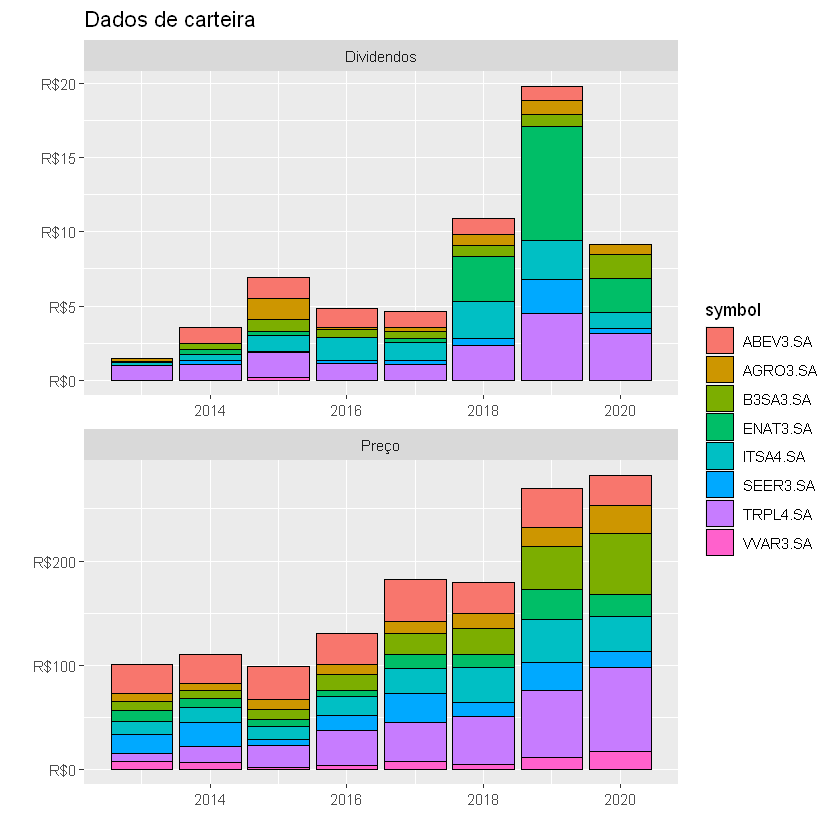

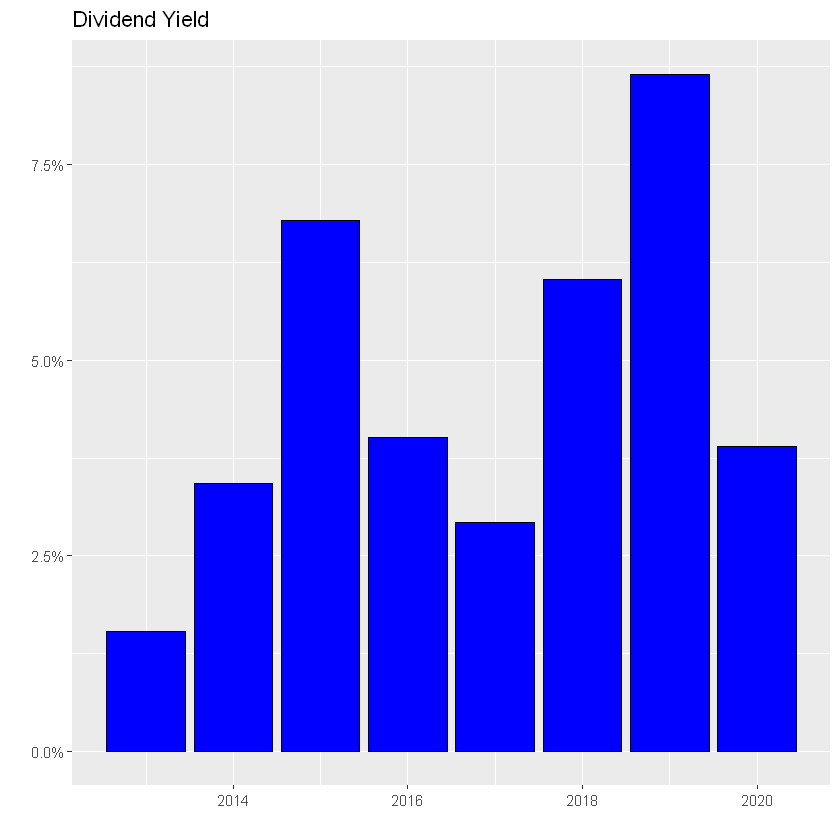

In [42]:
ggplot(tot_g, aes(x = ano, y = prices, fill = symbol))+
  geom_col(col = "black")+
  labs(x = "", y = "", title = "Dados de carteira")+
  scale_y_continuous(labels = scales::dollar_format(prefix = "R$"))+
  facet_wrap(~data, nrow = 3, scales = "free")
ggplot(dy, aes(x = ano, y = dy))+
  geom_col(fill = "blue", col = "black")+
  labs(x = "", y = "", title = "Dividend Yield")+
  scale_y_continuous(labels = scales::percent)

`summarise()` ungrouping output (override with `.groups` argument)



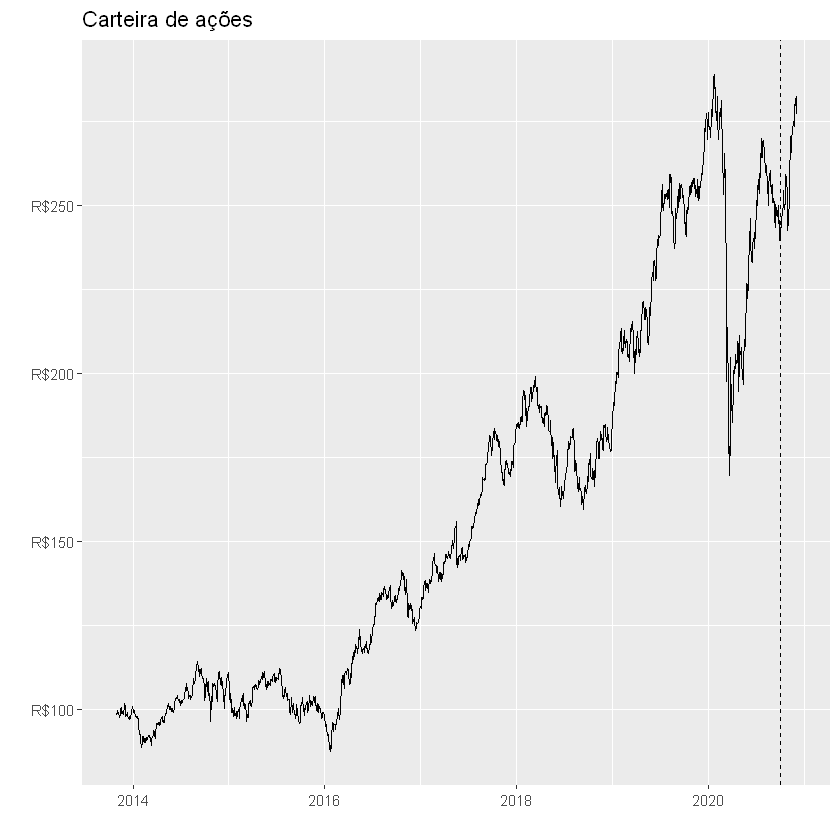

In [43]:
carteira <- tot %>%
  group_by(date) %>%
  summarise(carteira = sum(adjusted), dividendos = sum(value))
carteira$variacao <- c(0,diff(carteira$carteira)/carteira$carteira[2:nrow(carteira)-1])
carteira$drawdown <- carteira$carteira/cummax(carteira$carteira)-1
ggplot(carteira, aes(x = date, y = carteira))+
  geom_line()+
  labs(x = "", y = "", title = "Carteira de ações")+
  scale_y_continuous(labels = scales::dollar_format(prefix = "R$"))+
  geom_vline(xintercept = as.Date(mudanca_recente), lty = 2)

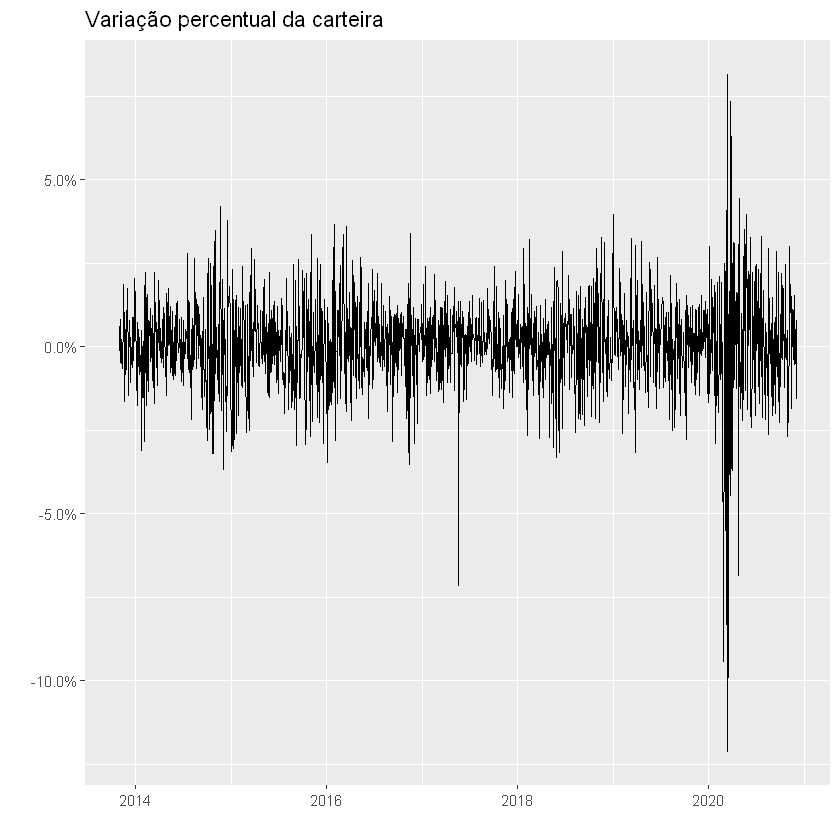

In [44]:
ggplot(carteira, aes(x = date, y = variacao))+
  geom_line()+
  labs(x = "", y = "", title = "Variação percentual da carteira")+
  scale_y_continuous(labels = scales::percent)

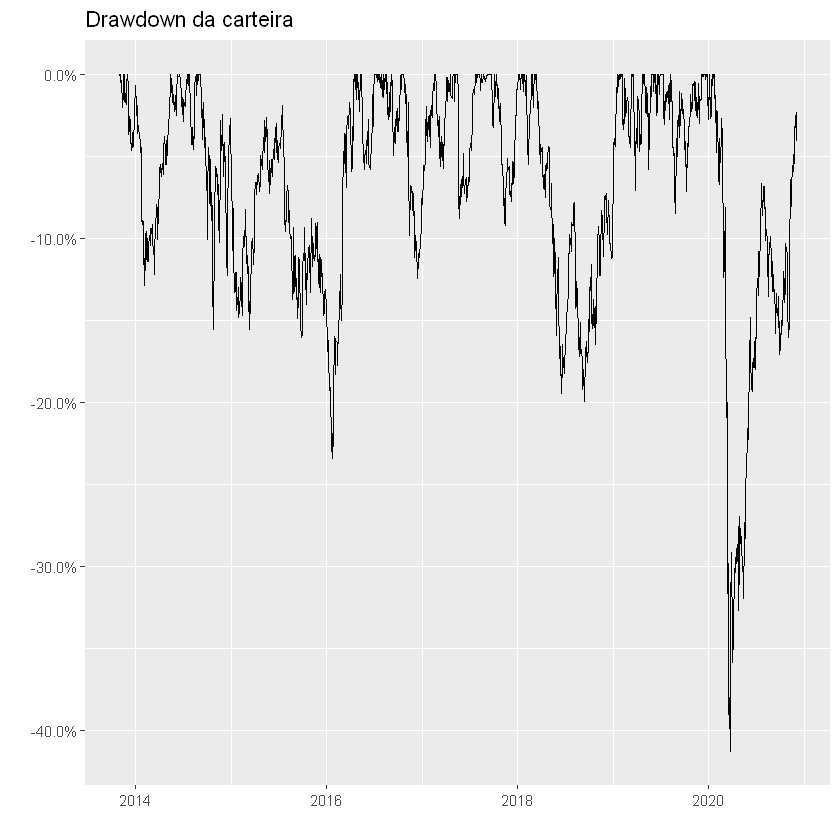

In [45]:
ggplot(carteira, aes(x = date, y = drawdown))+
  geom_line()+
  labs(x = "", y = "", title = "Drawdown da carteira")+
  scale_y_continuous(labels = scales::percent)

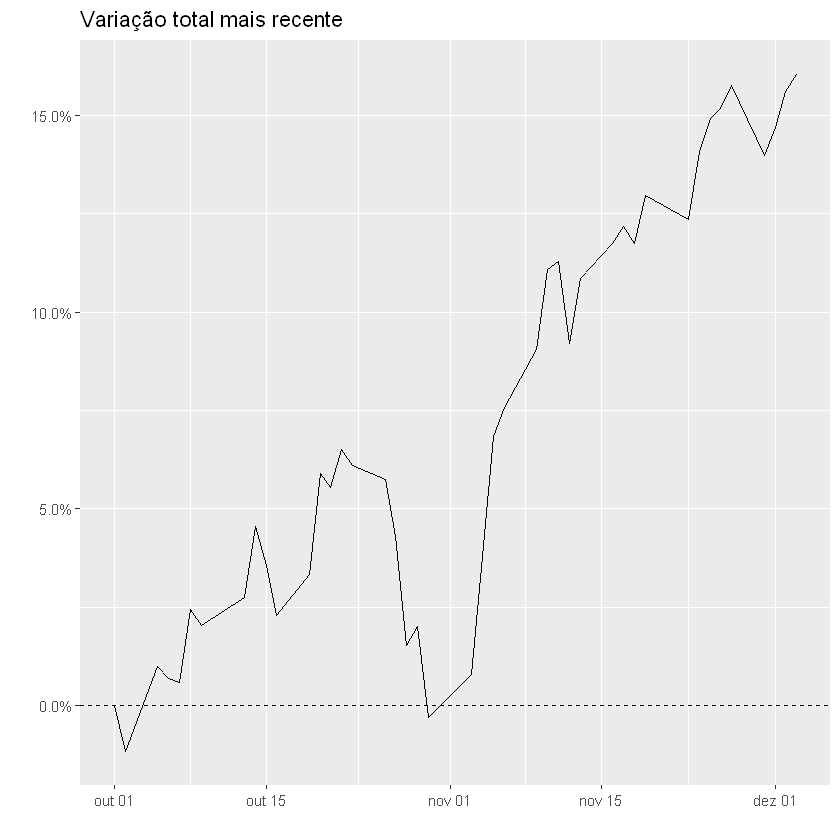

In [46]:
carteira_rec <- carteira %>%
  filter(date >= mudanca_recente) %>%
  summarise(date,carteira, variacao, dividendos)
carteira_rec$variacao_tot <- cumprod(c(0,carteira_rec$variacao[2:nrow(carteira_rec)])+1)-1
ggplot(carteira_rec, aes(x = date, y = variacao_tot))+
  geom_line()+
  labs(x = "", y = "", title = "Variação total mais recente")+
  scale_y_continuous(labels = scales::percent)+
  geom_hline(yintercept = 0, lty = 2)

In [47]:
xts::last(carteira_rec,10)

date,carteira,variacao,dividendos,variacao_tot
<date>,<dbl>,<dbl>,<dbl>,<dbl>
2020-11-19,274.9092,0.010809657,0.00,0.1295821
2020-11-23,273.4493,-0.005310666,0.00,0.1235833
2020-11-24,277.6680,0.015427721,0.00,0.1409176
2020-11-25,279.7288,0.007422001,0.00,0.1493855
2020-11-26,280.3293,0.002146554,0.00,0.1518527
2020-11-27,281.7678,0.005131533,0.00,0.1577635
2020-11-30,277.4400,-0.015359396,0.00,0.1399810
2020-12-01,279.1400,0.006127447,0.06,0.1469661
2020-12-02,281.3500,0.007917174,0.00,0.1560469


In [48]:
precos %>%
  filter(date == last(date)) %>%
  summarise(symbol,adjusted = adjusted/sum(adjusted))

symbol,adjusted
<chr>,<dbl>
ABEV3.SA,0.10408922
AGRO3.SA,0.09371570
B3SA3.SA,0.20849708
ENAT3.SA,0.07371216
ITSA4.SA,0.11885289
SEER3.SA,0.05406267
TRPL4.SA,0.28613915
VVAR3.SA,0.06093113


In [34]:
#Coletando os dados
s <- tq_get(acoes, from = data_inicio)

In [35]:
#Mudando os dados
month_retun <- s %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun = periodReturn, period = "monthly")
daily_retunr <- s %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun = periodReturn, period = "daily")
retornos_m <- month_retun %>%
  mutate(year = year(date)) %>%
  group_by(symbol, year) %>%
  summarise(Retorno_Mensal_Médio = mean(monthly.returns),
            Desvio_Mensal = sd(monthly.returns)) %>%
  gather(Retorno_Mensal_Médio, Desvio_Mensal, key = statistic, value = value)
retornos <- daily_retunr %>%
  mutate(year = year(date)) %>%
  group_by(symbol, year) %>%
  summarise(Retorno_Diário = mean(daily.returns),
            Desvio_Padrão = sd(daily.returns)) %>%
  gather(Retorno_Diário, Desvio_Padrão, key = statistic, value = value)

`summarise()` regrouping output by 'symbol' (override with `.groups` argument)

`summarise()` regrouping output by 'symbol' (override with `.groups` argument)



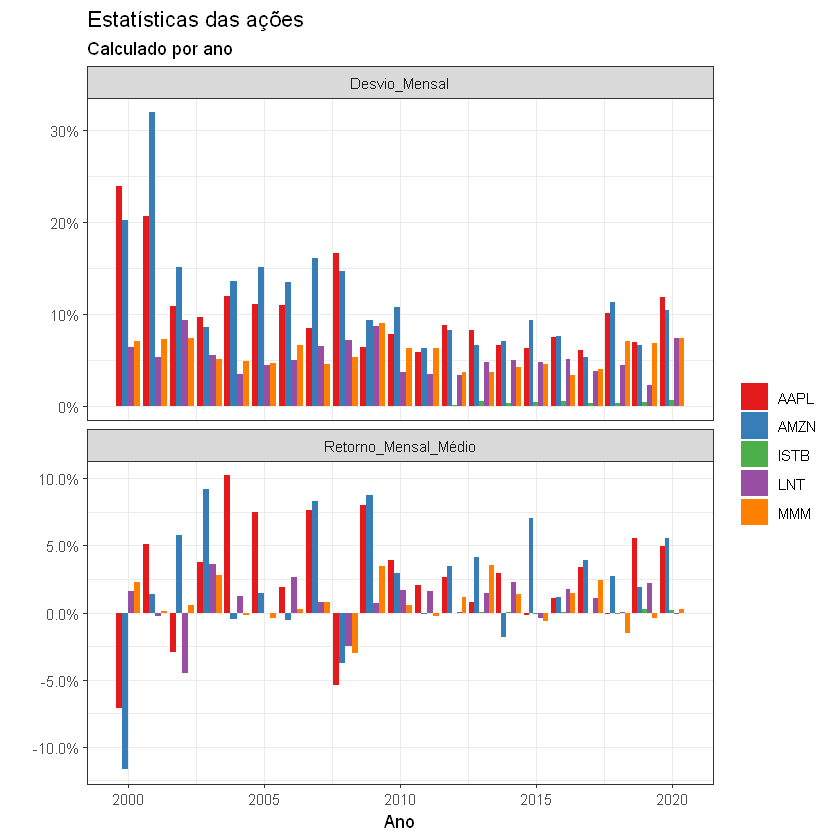

In [36]:
#Gráficos
retornos_m %>%
  ggplot(aes(year,value))+
  geom_col(aes(fill = symbol), position = "dodge")+
  scale_y_continuous(labels = scales::percent)+
  theme_bw()+
  scale_fill_brewer(palette = "Set1",
                    name = "")+
  facet_wrap(~statistic, scales = "free_y", nrow = 2)+
  labs(x = "Ano", y = "", title = "Estatísticas das ações",
      subtitle = "Calculado por ano")

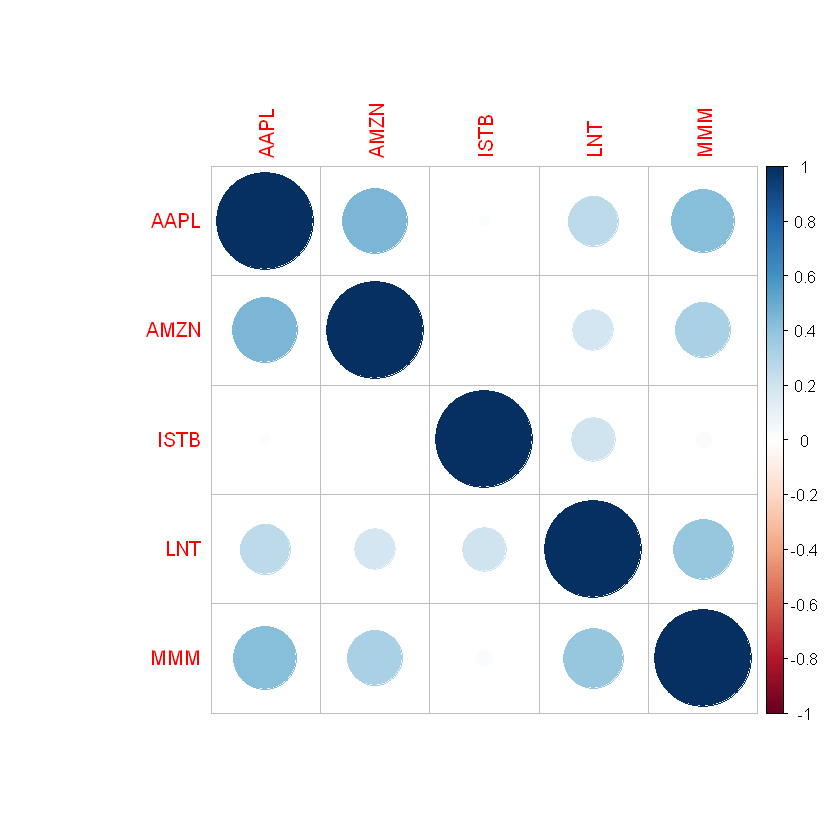

In [37]:
correlacao <- daily_retunr %>%
  spread(key = symbol, value = daily.returns) %>%
  na.omit()
correlacao <- cor(correlacao[,-1])
corrplot(correlacao)

In [38]:
correlacao

,AAPL,AMZN,ISTB,LNT,MMM
AAPL,1.00000000,0.452950314,0.013086478,0.2673337,0.42944874
AMZN,0.45295031,1.000000000,0.001268529,0.1856501,0.32169474
ISTB,0.01308648,0.001268529,1.000000000,0.2092422,0.02914446
LNT,0.26733370,0.185650090,0.209242205,1.0000000,0.38330926
MMM,0.42944874,0.321694742,0.029144460,0.3833093,1.00000000
